# Cleaning Notebook

Before conducting EDA and building the data needs to be formatted in a way that won't throw errors. In a combination of initial exploration and later EDA the following steps are needed:

1. Creating Columns 
2. Converting to Appropriate Datatype
3. Handling Nulls
4. Cleaning Text
5. Dealing Duplicate Values Left Over from Merging Madness

### Importing libarires

For this notebook we'll use pandas, regex (for cleaning text), and seaborn (for visualizations).

In [29]:
import pandas as pd
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt

# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from nltk.tokenize import RegexpTokenizer
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# from sklearn.feature_extraction import stop_words, text

# This creates HD resolution for visualizations

%config InlineBackend.figure_format = 'retina'

#### Reading in the data, checking the shape and first few rows.

An initial look at the dataframe reveals that the text for `answers_body` has several HTML artifacts. In the NLP cleaning later we'll remove these as well as clean other text columns are a precaution. 

<span style ='color:red'> include? Or move to merge notebook?? Should start off with a bang
One of the things we notice off the bat is that size is 180K rows. From the merging we notebooks we know that this is an error from merging. Through EDA and cleaning this error persists and essentially gives us unbalanced classes while merging. Due to limited time, we weren't able to fix this error. For better results, I recommend fixing this issue. 

In [28]:
data = pd.read_csv('./Datasets/merged_df.csv')
print("shape:", data.shape)
data.head(2)

shape: (180376, 13)


,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,questions_score,tag_id,tag_name,answers_id,answers_author_id,answers_date_added,answers_body,answers_score
0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26 UTC+0000,Teacher career question,What is a maths teacher? what is a ma...,1.0,14147.0,lecture,4e5f01128cae4f6d8fd697cec5dca60c,36ff3b3666df400f956f8335cf53e09e,2016-04-29 19:40:14 UTC+0000,<p>Hi!</p>\n<p>You are asking a very interesti...,0.0
1,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26 UTC+0000,Teacher career question,What is a maths teacher? what is a ma...,1.0,27490.0,college,4e5f01128cae4f6d8fd697cec5dca60c,36ff3b3666df400f956f8335cf53e09e,2016-04-29 19:40:14 UTC+0000,<p>Hi!</p>\n<p>You are asking a very interesti...,0.0


Data.describe() reveals a quick overview of the numeric columns. A peruse over the stats shows that there are no noticible outliers that need to be cleaned.

In [3]:
data.describe()

,questions_score,tag_id,answers_score
count,180350.000000,178676.000000,177990.000000
mean,4.873818,17010.555682,0.454424
std,7.537048,10196.886662,0.940910
min,0.000000,27.000000,0.000000
25%,2.000000,11051.000000,0.000000
50%,4.000000,18356.000000,0.000000
75%,5.000000,25647.000000,1.000000
max,125.000000,39250.000000,30.000000


By checking the datatypes I discovered:
1. Dates are saved as *objects* we'll change these laters
2. Id's are stored as *objects*, in checking the dataframe above we see that id's use both numbers and letters and shouldn't be converted to another datatype. That said, when doing our NLP training these should be treated differently than the other *object* columns

In [4]:
data.dtypes

questions_id             object
questions_author_id      object
questions_date_added     object
questions_title          object
questions_body           object
questions_score         float64
tag_id                  float64
tag_name                 object
answers_id               object
answers_author_id        object
answers_date_added       object
answers_body             object
answers_score           float64
dtype: object

In [ ]:
#### Creating a `date_cols` list so we can loop through and convert dates to date_time data type

date_cols = []

for cols in data.columns:
    if "date" in cols:
        date_cols.append(cols)
        
date_cols

#### Converting Date Columns to *Date* type

for cols in date_cols:
    data[cols] = pd.to_datetime(data[cols])
    
data.dtypes

#### Extracting columns which are *object* oriented type and saving them as a list called `str_cols`. We do this so we can easily process all the *object* types in the `cleaning_text` function.


In [ ]:
str_cols = data.select_dtypes(include ='object').columns
str_cols

After looking at the various *object* type columns I realize that the `id` columns shouldn't be treated as a string. Since they include both numbers and letters, we can't convert them into an integer. So instead let's create a list, `text_cols` that has all *object* type columns excluding the `id` columns.

#### Using a for loop to create `text_cols` list which is a list of columns that are text based (*object* columns that aren't `id` columns)


In [ ]:
text_cols = [] #create a list

for cols in str_cols: # looping through the `str_cols` variable

    if "id" not in cols: # if `id` isn't in the name 
        text_cols.append(cols) # append to `text_cols` list

text_cols

### Creating Boolean Columns

Before we handle nulls, we want to know if 1) the question was answered and 2) if the question was tagged or not. To do this, we selected an answer and tag column and mapped 0 where there were nulls and 1 for not-nulls to the new `qa_match` and `has_tag` columns. 

#### Creating a "Was Answered" Column
    
Creating a column called `qa_match`, to indicate if the question was answered. `0` if there no answer and `1` if there is. 

In [5]:
# Create a new column called `qa_match`
# Where there are notnulls in a `answer_id`: label 1, if there are nulls: label 0

data['qa_match'] = data['answers_id'].notnull().astype(int)

#### Creating a `has_tag` column

This columns has 1 if the row has a tag, and 0, if it doesn't. 

In [ ]:
# Create a new column called `has_tag`
# Where there are notnulls in a `tag_id`: label 1, if there are nulls: label 0

data['has_tag'] = data['tag_id'].notnull().astype(int)

### Handling Nulls:

Many of our models and code doesn't work when null values are present. We need to either delete or fill the nulls so that later we won't incur any errors.

A major contributor to nulls in this dataset is from how the data was given to us. There were 15 datasets that didn't perfectly match. We had to choose to either duplicate/create information or to lose information. Since making up information creates more issues, we choose to deal with a large number of nulls values. 

First, we need to check for nulls.

## <span style = 'color:red'> For now we're just filling nulls.


In [6]:
data.isnull().sum()

questions_id               0
questions_author_id        0
questions_date_added       0
questions_title            0
questions_body             0
questions_score           26
tag_id                  1700
tag_name                1700
answers_id              2340
answers_author_id       2340
answers_date_added      2340
answers_body            2344
answers_score           2386
qa_match                   0
dtype: int64

#### Creating a visual to get an idea of where the nulls are. 

Null values are represented by black lines, as we can see there are systematic nulls

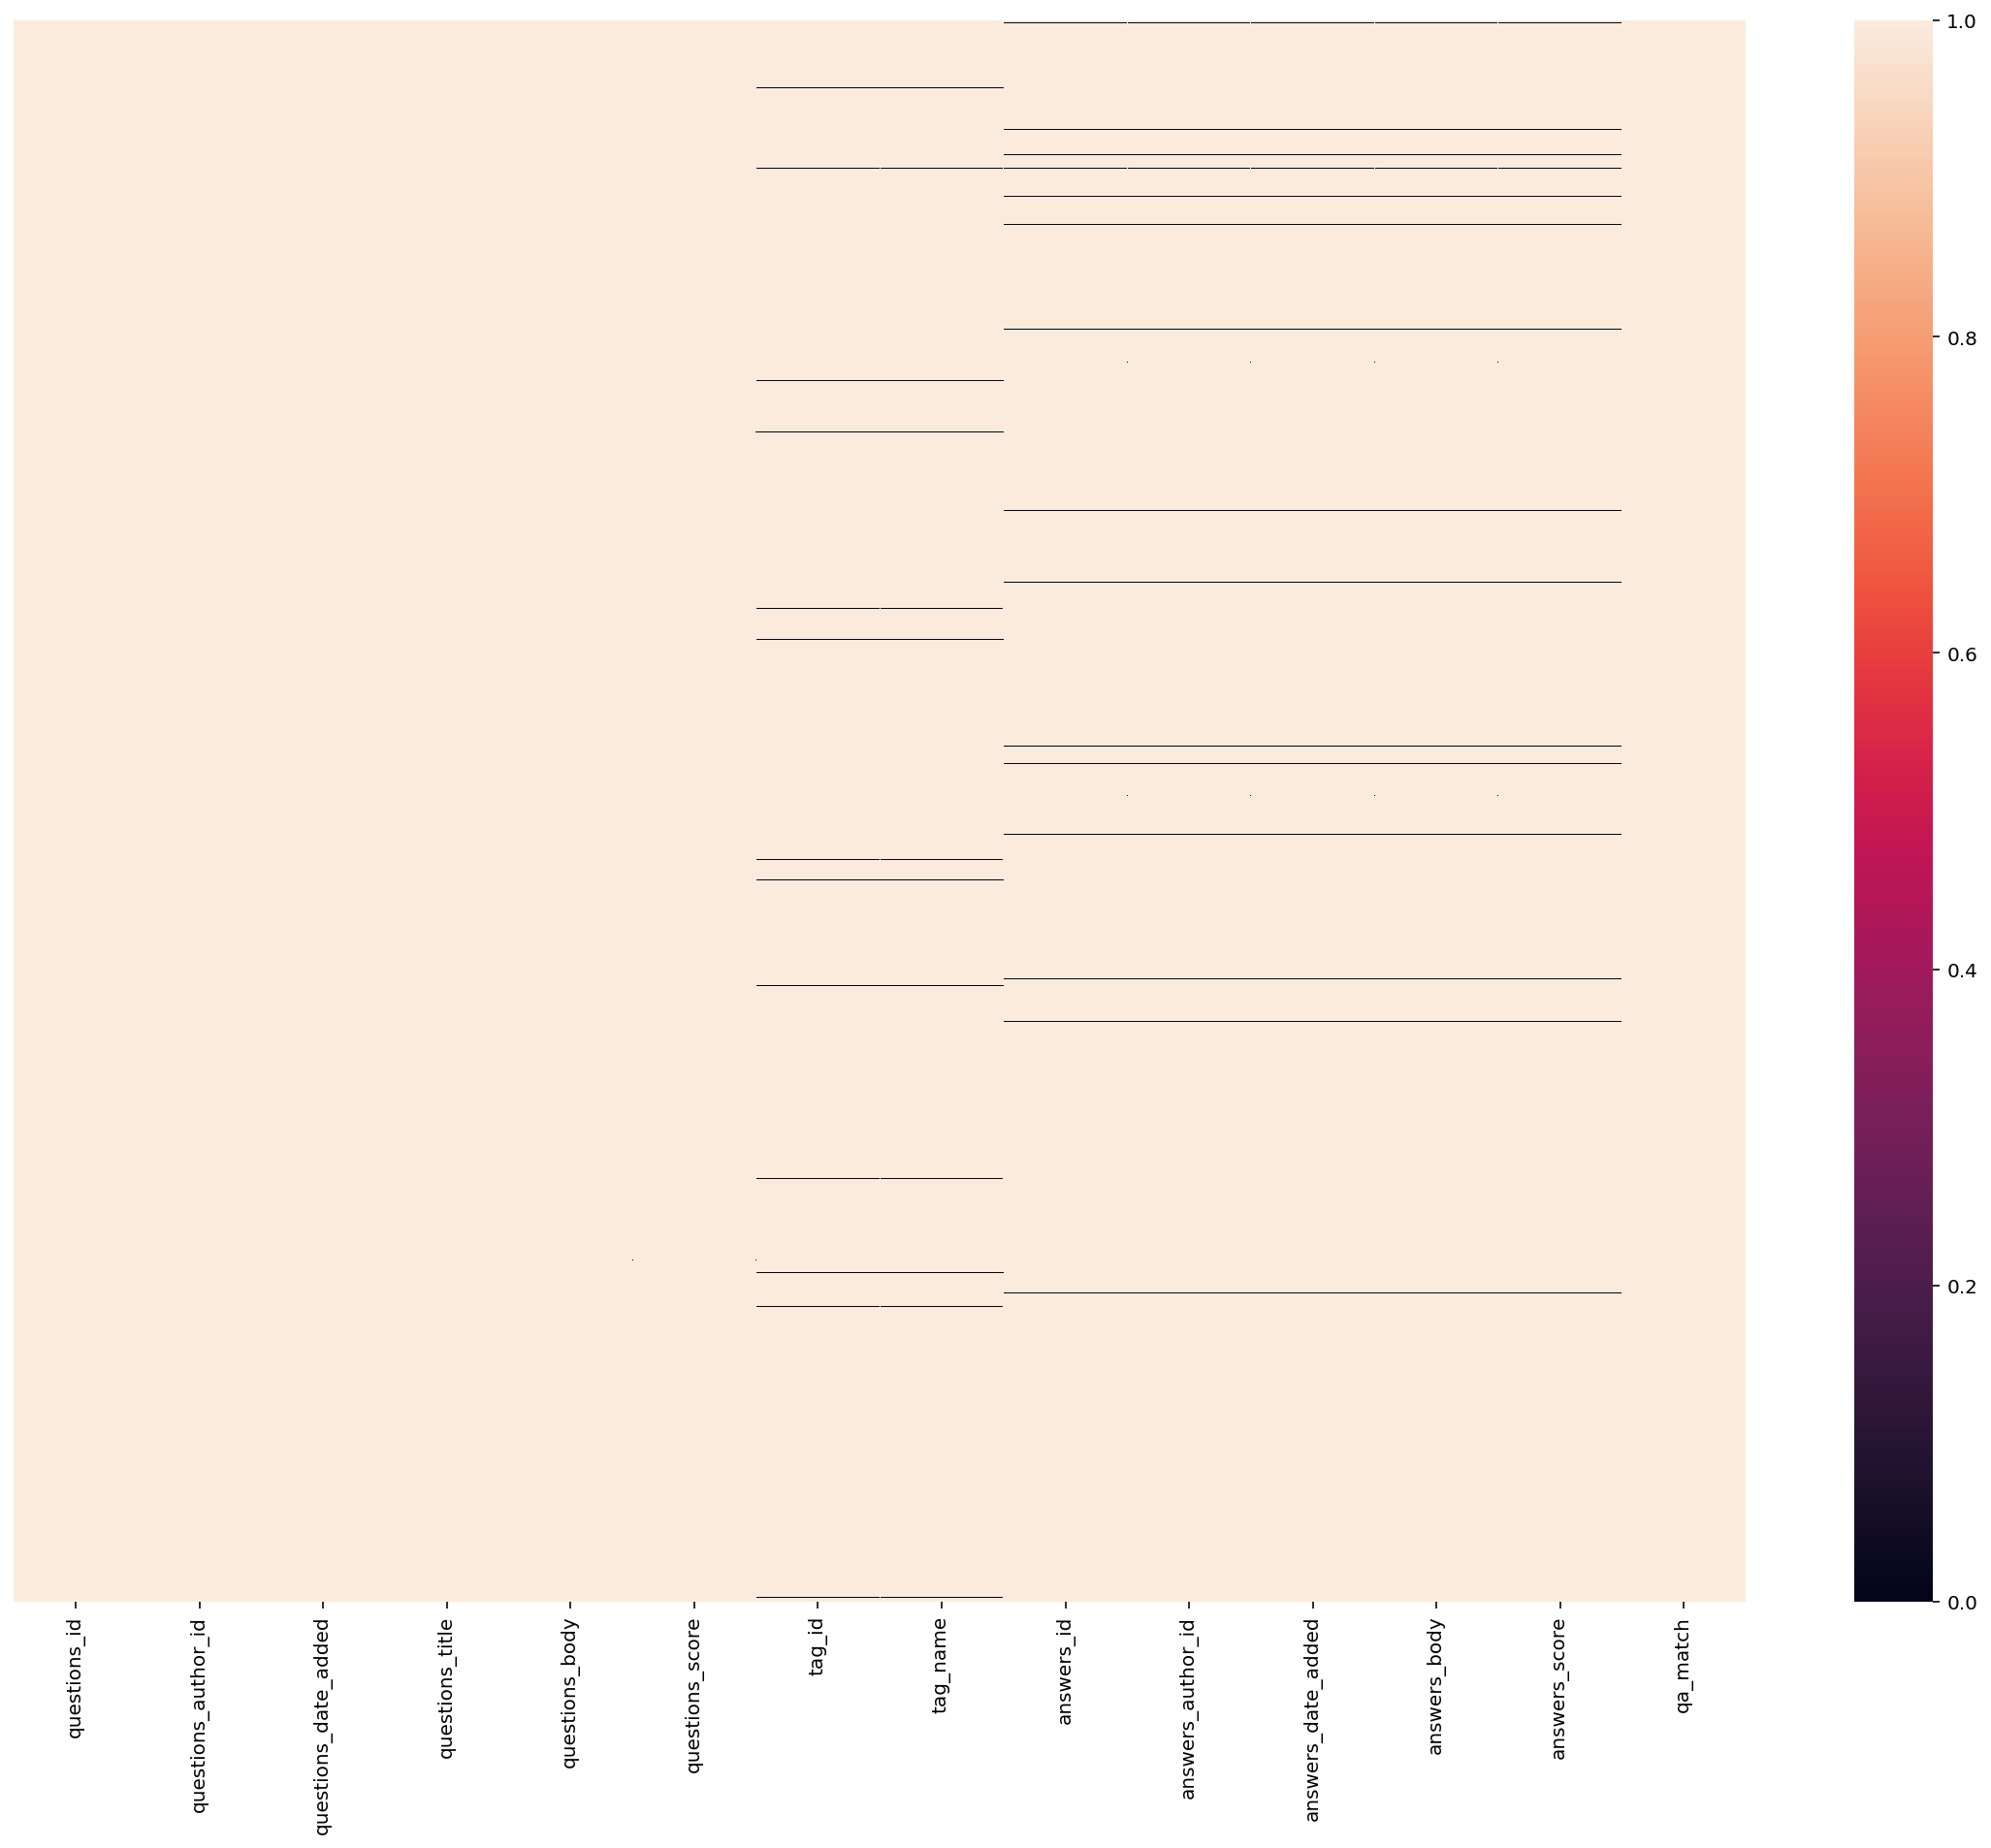

In [27]:
# test_df = data.notnull().astype(int)

# plt.subplots(figsize=(20,15))

# sns.heatmap(test_df, yticklabels = "");

## <span style = 'color:red'> Fix: this is just a place holder, need to fix in the long run

#### Filling integer nulls with '0'
    
should have filled in with the mean - or could be dealing with the issue above where things got duplicated in a really weird way.

In [7]:
data['answers_score'].fillna(0, inplace=True)

#### For columns with 'object' type data, we're replacing nulls with "none"

In [8]:
# str_nulls = ['answers_body', 'questions_author_id', 'questions_title', 'questions_body', 'tag_name']

# for cols in str_nulls:
#     data[cols].fillna("none", inplace=True)

#### Replace columns with `interger/float` data type with 0

In [9]:
int_nulls = ['tag_id', 'questions_score']

for cols in int_nulls:
    data[cols].fillna(0, inplace=True)

#### Checking if each column has duplicate values and how many

Because of the complications with merging I wanted to check how dirty the data was. That is, how many rows have been duplicated with only one column being different. 

First, I checked if there are duplicate rows. There weren't, so we know that at least one value in a row is different. 

### <span style ='color:red'> insert image or make heatmap representing the data

In [30]:
data.duplicated().sum()

0

Since there are no duplicate rows, we're no checking which columns have duplicate values. 

Below the for-loop iterates through each of the columns, runs the method `.duplicated()` to get boolean values then `.sum()` to get a count of how many duplicate values are in that column.

### <span style ='color:red'> Keep in mind null values will show up as the same. Also, keep in mind where rows would be the same, maybe create a should be a unique variable

In [11]:
for col in data.columns:  #Iterates through all the columns in the data frame
    duplicate_sum = data[col].duplicated().sum()  #saves the sum
    if duplicate_sum > 0:                                     #If there are more than 0 sums, print:
        print(f"{col}:   {duplicate_sum} duplicate values")
    else:
        continue

questions_id:   156445 duplicate values
questions_author_id:   168047 duplicate values
questions_date_added:   156507 duplicate values
questions_title:   156637 duplicate values
questions_body:   156695 duplicate values
questions_score:   180301 duplicate values
tag_id:   173284 duplicate values
tag_name:   173284 duplicate values
answers_id:   129252 duplicate values
answers_author_id:   170206 duplicate values
answers_date_added:   129313 duplicate values
answers_body:   129974 duplicate values
answers_score:   180353 duplicate values
qa_match:   180374 duplicate values


Similiarly to checking duplicates, we're also checking how many unique values are in each column. 

#### <span style='color:red'> explain more

In [36]:
print("unique values per column:")
print("")

for col in data.columns:  #Iterates through all the columns in the data frame
    print(f"{data[col].nunique()} - {col}")

unique values per column:

23931 - questions_id
12329 - questions_author_id
23869 - questions_date_added
23739 - questions_title
23681 - questions_body
75 - questions_score
7091 - tag_id
7091 - tag_name
51123 - answers_id
10169 - answers_author_id
51062 - answers_date_added
50401 - answers_body
23 - answers_score


## Natural Language Processing Cleaning

Since we want to explore the text data and build models form the text we need to clean the text to get the best results. 

#### <span style='color:red'> explain more

#### Setting up a Cleaning Text Function: 

The function takes in a column and cleans the text for preproccessing. It removes html artifacts as well as punctuation and numbers, and converts the text to all lower case. 

In [13]:
def cleaning_text(df, df_col):
    """
    df: is the name of Dataframe 
    df_col: takes in a column name formated as string i.e. "column_name" 
    
    This function takes a column and cleans the text for that column. 
    It removes HTML artifacts suchs as <p> and <br> as as well as punctuation, 
    and numbers preparing it for processing and modeling. 
    In addition it makes all the text lower case.
    It utilizes the .replace method as well as regex. 
    It outputs the top 2 rows
    
    If you haven't yet, the code to import regex is:
    import regex as re 
    #you need to regex import as re or else this code will break
    """

    # Uses .str.reaplce
    df[df_col] = df[df_col].str.replace("<p>", "") #removes <p>
    df[df_col] = df[df_col].str.replace("</p>","") #removes </p>
    df[df_col] = df[df_col].str.replace("<br>", "") #removes <br>
    df[df_col] = df[df_col].str.replace("\n", "")   #removes <\n>
    
    #Makes everything lower case
    df[df_col] = df[df_col].str.lower()
    
    # Using regex and lambda 
    df[df_col] = df[df_col].map(lambda x: re.sub('\/\/', ' ', x)) # Removing line breaks
    df[df_col] = df[df_col].map(lambda x: re.sub('[\\][\']', '', x)) # Removing apostrophes
    df[df_col] = df[df_col].map(lambda x: re.sub('[^\w\s]', ' ', x)) # Removing all punctuation 
    df[df_col] = df[df_col].map(lambda x: re.sub('\xa0', ' ', x)) # removing xa0
    df[df_col] = df[df_col].map(lambda x: re.sub('\s[\/]?r\/[^\s]+', ' ', x)) # removing mentions of any subreddit
    df[df_col] = df[df_col].map(lambda x: re.sub('http[s]?:\/\/[^\s]*', ' ', x)) # removing urls
    
    # Keeping numbers for now, if we want to strip numbers, use the below
    df[df_col] = df[df_col].map(lambda x: re.sub("[^a-zA-Z]", " ", x)) # Removes all numbers only keeping letters
    
    #Displays the top 2 rows
    return df[df_col].head(2)

#### For loop interates through `text_cols` list (all the *object* oriented columns) and cleans the text using `cleaning_text()` function. 

In [18]:
for cols in text_cols:
    if data[cols].isnull().sum() == 0: #If there aren't any nulls 
        cleaning_text(data, cols) #Call `cleaning_text` function
    else:
        print(f"{cols} has null values, so we're filling with 'none', then calling `cleaning_tex()` function") #print which columns have nulls 
        
        #Filling nulls with 'none'
        data[cols].fillna('none', inplace =True)
        
        #Then calling the function
        cleaning_text(data, cols) #Call `cleaning_text` function

tag_name has null values, so we're filling with 'none', then calling `cleaning_tex()` function
answers_body has null values, so we're filling with 'none', then calling `cleaning_tex()` function


In [19]:
data.head(2)

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,questions_score,tag_id,tag_name,answers_id,answers_author_id,answers_date_added,answers_body,answers_score,qa_match
0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26+00:00,teacher career question,what is a maths teacher what is a ma...,1.0,14147.0,lecture,4e5f01128cae4f6d8fd697cec5dca60c,36ff3b3666df400f956f8335cf53e09e,2016-04-29 19:40:14+00:00,hi you are asking a very interesting question ...,0.0,1
1,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26+00:00,teacher career question,what is a maths teacher what is a ma...,1.0,27490.0,college,4e5f01128cae4f6d8fd697cec5dca60c,36ff3b3666df400f956f8335cf53e09e,2016-04-29 19:40:14+00:00,hi you are asking a very interesting question ...,0.0,1


## Exporting Data

In [22]:
data.to_csv('./Datasets/cleaned.csv', index=False)